## Preprocess raw ECG data recorded with MAX85150 with digital filters
**Written by: Stamatios Aleiferis**

In [2]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import scipy as sp
import pandas as pd

import wfdb
import wfdb.processing

In [3]:
# Read sensor data
data = pd.read_csv('ECPPG_2020-01-07_01-07-14.csv')

/Users/stamatios/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
Fs = 200 # ECG sample rate in Hz
rawECG = data.values[:,5][1:].astype(np.float)[600:-1000]
filteredECG = data.values[:,7][1:].astype(np.float)[600:-1000] # Max-filtered data
N = len(rawECG)

In [5]:
#f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))

Text(0.5, 1.0, 'Raw ECG')

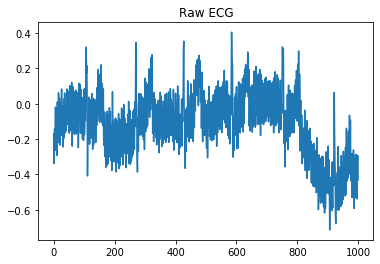

In [6]:
plt.plot(rawECG[1800:2800])
plt.title('Raw ECG')

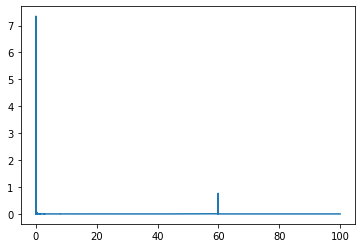

In [8]:
f,Pxx_raw=sp.signal.periodogram(rawECG,200)


#plt.plot(FFT)
plt.plot(f,Pxx_raw)

# 60 Hz notch design

In [9]:
#IIR notch
f0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 40.0  # Quality factor
# Design notch filter
b, a = sp.signal.iirnotch(f0, Q, Fs)
b2, a2 = sp.signal.iirnotch(80.0, Q, Fs)

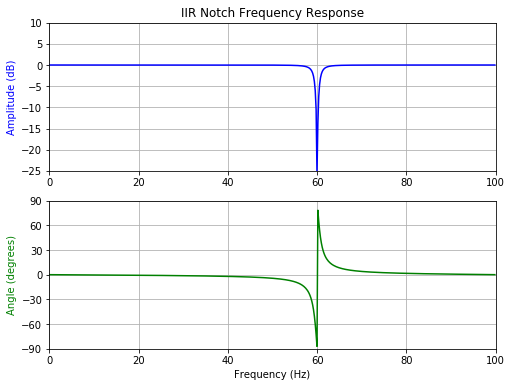

In [10]:
# Frequency response
freq, h = sp.signal.freqz(b, a, fs=Fs)
# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("IIR Notch Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid()
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid()
plt.show()

## Apply notch

(0, 0.005)

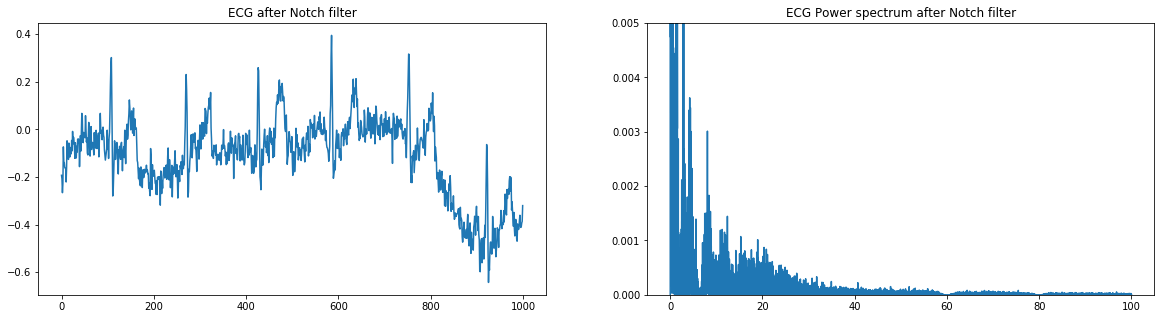

In [12]:
notchedECG = sp.signal.filtfilt(b,a,rawECG)
notchedECG = sp.signal.filtfilt(b,a,notchedECG)
notchedECG = sp.signal.filtfilt(b2,a2,notchedECG)

f,Pxx=sp.signal.periodogram(notchedECG,200)
_,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))

ax1.plot(notchedECG[1800:2800])
#ax1.plot(filteredECG[1800:2800])
ax1.set_title('ECG after Notch filter')

ax2.plot(f,Pxx)
ax2.set_title('ECG Power spectrum after Notch filter')
ax2.set_ylim((0,0.005))




# Bandpass design

In [1669]:
# IIR butterworth
b_BPF, a_BPF = sp.signal.butter(15, [30], btype='high', analog=False, output='ba', fs=Fs) # Butterworth Bandpass 3-25 Hz
b_LPF, a_LPF = sp.signal.butter(15, [40], btype='lowpass', analog=False, output='ba', fs=Fs) # Butterworth Bandpass 3-25 Hz


In [13]:
# Design FIR with window method
from bandpass_wrappers import *

In [14]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 200.0
lowcut = 2
highcut = 40

ntaps = 128
taps_hamming = bandpass_firwin(ntaps, lowcut, highcut, fs=fs)
taps_kaiser16 = bandpass_kaiser(ntaps, lowcut, highcut, fs=fs, width=1.6)
taps_kaiser10 = bandpass_kaiser(ntaps, lowcut, highcut, fs=fs, width=1.0)
remez_width = 1.0
taps_remez = bandpass_remez(ntaps, lowcut, highcut, fs=fs,
                            width=remez_width)
lsFilter = sp.signal.firls(33, [0,8,30, (Fs/2)-1], [0,1,1,0], weight=None, nyq=None, fs=Fs)

## Bandpass filter the ECG signal

Text(0.5, 1.0, 'Bandpasss filtered signal')

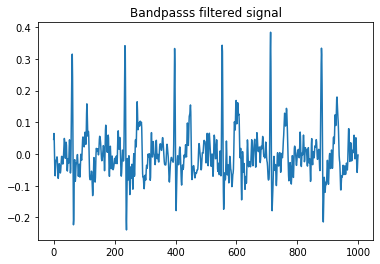

In [15]:
# Apply butterworth bandpass
#filtECG = sp.signal.lfilter(b_BPF,a_BPF,filteredECG)
#filtECG = sp.signal.lfilter(b_LPF,a_LPF,filtECG)
#plt.plot(filtECG[1800:2300])

# Apply
filtECG = sp.signal.convolve(notchedECG, taps_kaiser10, mode='full', method='auto')
filtECG = sp.signal.convolve(filtECG, taps_kaiser16, mode='full', method='auto')
plt.plot(filtECG[1800:2800])
plt.title('Bandpasss filtered signal')

# Apply
#filtECG = sp.signal.convolve(notchedECG, lsFilter, mode='full', method='auto')
#plt.plot(filtECG[1800:2800])

# Bandpass ECG signal power spectrum

Text(0.5, 1.0, 'Power spectrum of Band-passed and Notch filtered ECG')

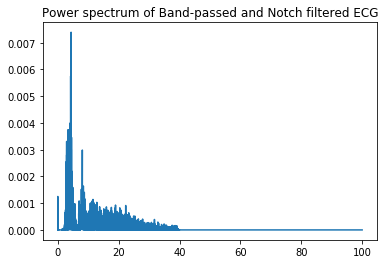

In [16]:
f,Pxx=sp.signal.periodogram(filtECG,200)
plt.plot(f,Pxx)
#plt.xlim((0,0.5))
#plt.ylim(())
plt.title("Power spectrum of Band-passed and Notch filtered ECG")

In [17]:
#notchedECG = (notchedECG-np.min(notchedECG))/(np.max(notchedECG)-np.min(notchedECG))

Text(0.5, 1.0, 'Differentiated Signal')

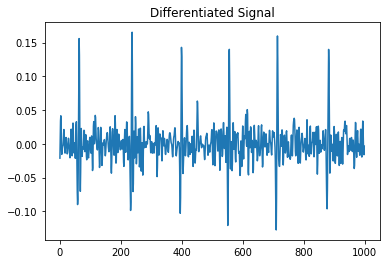

In [18]:
#  Derivative filter
der_h = (1/8) * np.array([-1, -2, 0, 2, 1])
derECG = sp.signal.convolve(filtECG, der_h, mode='full', method='auto')
derECG = derECG[2+np.array(range(N))]
plt.plot(derECG[1800:2800])
#plt.plot(np.diff(derECG)[1800:2800])
plt.title('Differentiated Signal')

Text(0.5, 1.0, 'Differentiated signal squared')

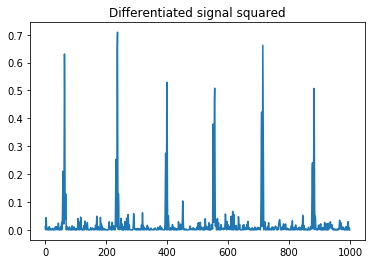

In [19]:
# Square ECG
sqECG = np.square(derECG/np.max(derECG))
#sqECG = np.square(derECG)
#plt.figure(figsize=(20,10))
plt.plot(sqECG[1800:2800])
plt.title("Differentiated signal squared")

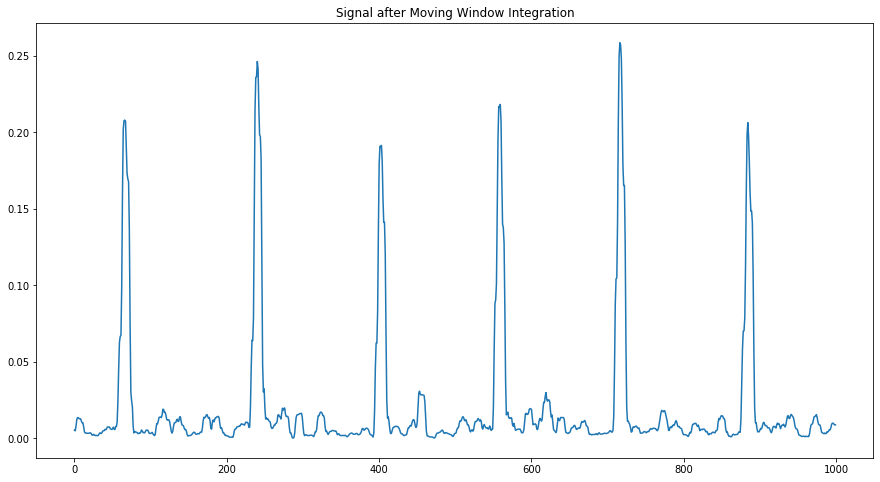

In [20]:
# Moving Window Integration
h = np.ones((10,))/10
movECG = sp.signal.convolve(sqECG, h, mode='full', method='auto')
plt.figure(figsize=(15,8))
plt.plot(movECG[1800:2800])
plt.title('Signal after Moving Window Integration');

In [22]:
## Calc HR
from ecgdetectors import Detectors

# R peak detector

In [23]:
detectorsMAX = Detectors(Fs)
r_peaks_MAX = detectorsMAX.engzee_detector(movECG)
#r_peaks_MAX = detectorsMAX.swt_detector(movECG)

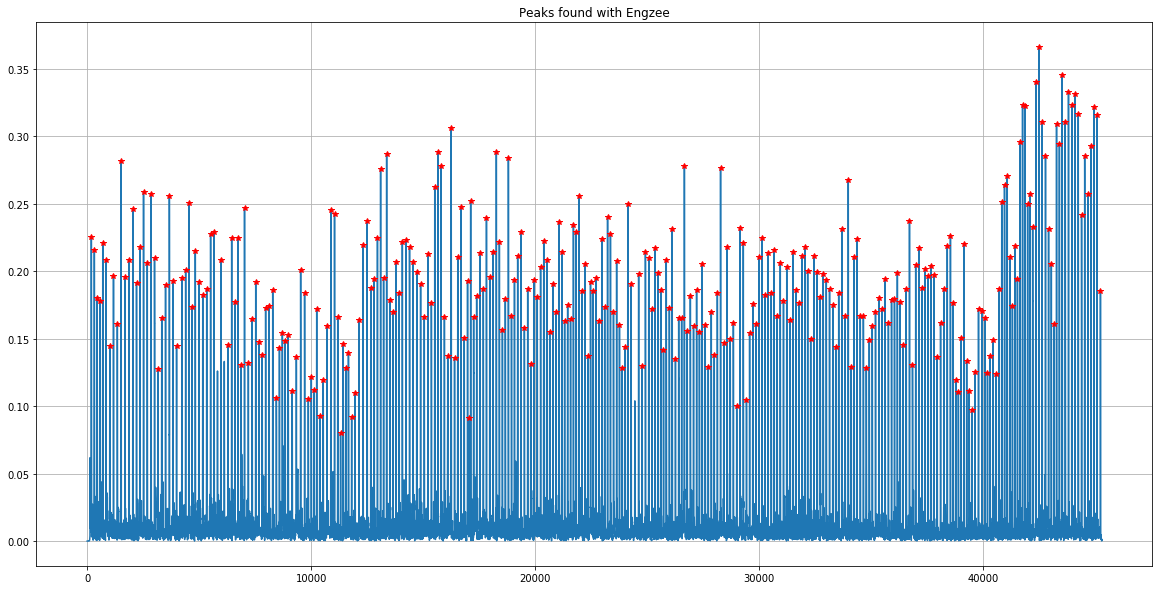

In [25]:
plt.figure(figsize=(20,10))
plt.plot(movECG)
plt.plot(r_peaks_MAX,movECG[r_peaks_MAX],'r*')
#plt.xlim((15000,17500))
#plt.xlim((10000,19700))
#plt.ylim((-1,2))
plt.title('Peaks found with Engzee')
plt.grid(True)

# Instantaneous heart rate

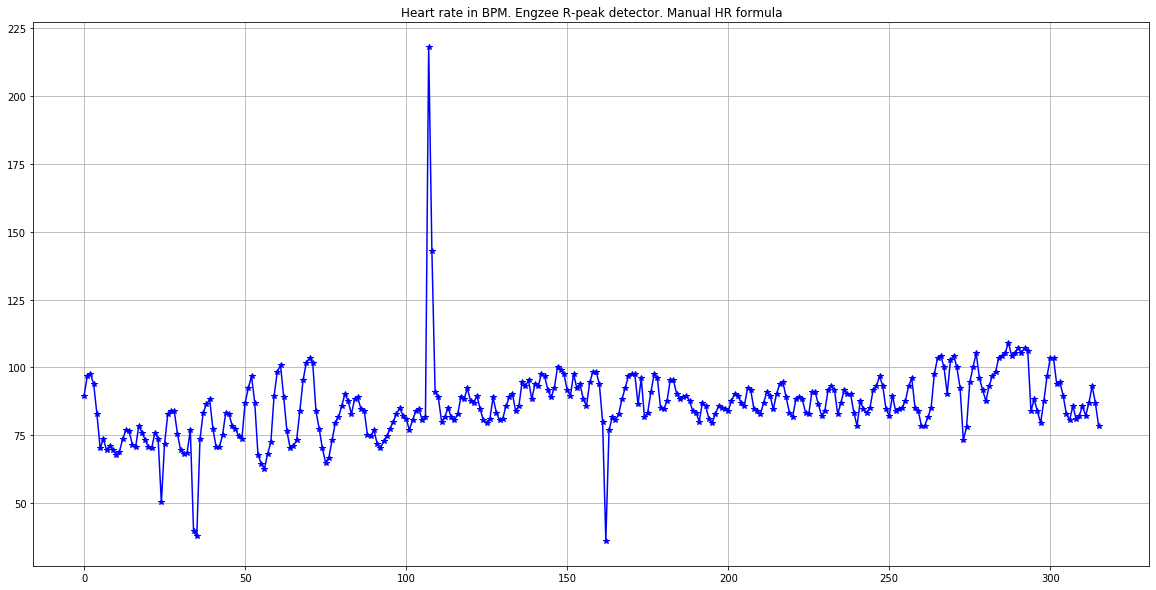

In [26]:
rr_s_interval = np.diff(r_peaks_MAX)
rr_interval = rr_s_interval *(1/Fs)
HR = 60/rr_interval 
#HR = sp.signal.convolve(HR,np.ones(9,)/9) # average over multiple heart beats
plt.figure(figsize=(20,10))
plt.plot(HR,'b-*')
#plt.xlim((10000,10700))
plt.title('Heart rate in BPM. Engzee R-peak detector. Manual HR formula')
plt.grid(True)